In [0]:
#!apt-get install --no-install-recommends openmpi-bin libopenmpi-dev libopencv-dev python3-opencv python-opencv && ln -sf /usr/lib/x86_64-linux-gnu/libmpi_cxx.so /usr/lib/x86_64-linux-gnu/libmpi_cxx.so.1 && ln -sf /usr/lib/x86_64-linux-gnu/openmpi/lib/libmpi.so /usr/lib/x86_64-linux-gnu/openmpi/lib/libmpi.so.12 && ln -sf /usr/lib/x86_64-linux-gnu/libmpi.so /usr/lib/x86_64-linux-gnu/libmpi.so.12 && pip install cntk

## Sequence to Sequence Model and Machine Tranlation

Sequence to Sequence model use recurrent neural nodes in their networks and have many-to-many relationship between their inputs and outputs. The model is composed of two main parts - (1) encoder , and (2) decoder - both of which are RNN layers. 

Encoder takes the model's input sequence and transform it into a fixed-size context vector.

Decoder uses the context vector from encoder into a 'seed' from which it generates an output sequence. 

<br>
The following program is the adapation of Mcricosft Online Learning on NLP using their Cognitive Toolkit.

In this task, we are dealing with Grapheme-to-Phoneme Translation. Grapheme are root words whereas Phoneme are their phonetic representation of the specific words.

For example, 
 > **Grapheme** : **|** T **|** A **|** N **|** G **|** E **|** R **|**  
**Phonemes** : **|** ~T **|** ~AE **|** ~NG **|** ~ER **|**





### Importing Libraries and Getting Data

In [0]:
#Importing Library

#from __future__ import print_function
import numpy as np
import os
import cntk as C 
import requests


In [0]:
### Getting the Data 

# For phoneme dictionary, we will use the CMUDict data - i.e open-source machine readable pronunciation dictionary from Carneige Mellon University http://www.speech.cs.cmu.edu/cgi-bin/cmudict.



def download(url, filename):
    """ utility function to download a file """
    response = requests.get(url, stream=True)
    with open(filename, "wb") as handle:
        for data in response.iter_content():
            handle.write(data)

MODEL_DIR = "."
DATA_DIR = os.path.join('..', 'Examples', 'SequenceToSequence', 'CMUDict', 'Data')
# If above directory does not exist, just use current.
if not os.path.exists(DATA_DIR):
    DATA_DIR = '.'

dataPath = {
  'validation': 'tiny.ctf',
  'training': 'cmudict-0.7b.train-dev-20-21.ctf',
  'testing': 'cmudict-0.7b.test.ctf',
  'vocab_file': 'cmudict-0.7b.mapping',
}

for k in sorted(dataPath.keys()):
    path = os.path.join(DATA_DIR, dataPath[k])
    if os.path.exists(path):
        print("Reusing locally cached:", path)
    else:
        print("Starting download:", dataPath[k])
        url = "https://github.com/Microsoft/CNTK/blob/v2.0/Examples/SequenceToSequence/CMUDict/Data/%s?raw=true"%dataPath[k]
        download(url, path)
        print("Download completed")
    dataPath[k] = path

Starting download: cmudict-0.7b.test.ctf
Download completed
Starting download: cmudict-0.7b.train-dev-20-21.ctf
Download completed
Starting download: tiny.ctf
Download completed
Starting download: cmudict-0.7b.mapping
Download completed


### The Vocabulary Reader 

In [0]:
# Helper function to load the model vocabulary file
def get_vocab(path):
    # get the vocab for printing output sequences in plaintext
    vocab = [w.strip() for w in open(path).readlines()]
    i2w = { i:w for i,w in enumerate(vocab) }
    w2i = { w:i for i,w in enumerate(vocab) }
    
    return (vocab, i2w, w2i)


# Read vocabulary data and generate their corresponding indices
vocab, i2w, w2i = get_vocab(dataPath['vocab_file'])


In [0]:
#vocab

In [0]:
## Setting up dimension for the Vocabulary

input_vocab_dim =69
label_vocab_dim = 69


print(len(vocab))
print(vocab[:])
print()
print(i2w)
print(w2i)

69
["'", '</s>', '<s/>', '<s>', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '~AA', '~AE', '~AH', '~AO', '~AW', '~AY', '~B', '~CH', '~D', '~DH', '~EH', '~ER', '~EY', '~F', '~G', '~HH', '~IH', '~IY', '~JH', '~K', '~L', '~M', '~N', '~NG', '~OW', '~OY', '~P', '~R', '~S', '~SH', '~T', '~TH', '~UH', '~UW', '~V', '~W', '~Y', '~Z', '~ZH']

{0: "'", 1: '</s>', 2: '<s/>', 3: '<s>', 4: 'A', 5: 'B', 6: 'C', 7: 'D', 8: 'E', 9: 'F', 10: 'G', 11: 'H', 12: 'I', 13: 'J', 14: 'K', 15: 'L', 16: 'M', 17: 'N', 18: 'O', 19: 'P', 20: 'Q', 21: 'R', 22: 'S', 23: 'T', 24: 'U', 25: 'V', 26: 'W', 27: 'X', 28: 'Y', 29: 'Z', 30: '~AA', 31: '~AE', 32: '~AH', 33: '~AO', 34: '~AW', 35: '~AY', 36: '~B', 37: '~CH', 38: '~D', 39: '~DH', 40: '~EH', 41: '~ER', 42: '~EY', 43: '~F', 44: '~G', 45: '~HH', 46: '~IH', 47: '~IY', 48: '~JH', 49: '~K', 50: '~L', 51: '~M', 52: '~N', 53: '~NG', 54: '~OW', 55: '~OY', 56: '~P', 57: '~R', 58: '~S', 59:

In [0]:
def create_reader(path, is_training):
    return C.io.MinibatchSource(C.io.CTFDeserializer(path, C.io.StreamDefs(
        features = C.io.StreamDef(field='S0', shape=input_vocab_dim, is_sparse=True),
        labels   = C.io.StreamDef(field='S1', shape=label_vocab_dim, is_sparse=True))), randomize = is_training, max_sweeps = C.io.INFINITELY_REPEAT if is_training else 1)

## Training and Validation- Data Reader

train_reader = create_reader (dataPath['training'], True)
valid_reader = create_reader (dataPath['validation'], True)

In [0]:
train_reader

<cntk.io.MinibatchSource; proxy of <Swig Object of type 'CNTK::MinibatchSourcePtr *' at 0x7ff33eaf0f00> >

In [0]:
### Defining the dimension of the Neural Network 

hidden_dim = 512
num_layers = 2
attention_dim = 128
attention_span = 20
attention_axis = -3
use_attention = True
use_embedding = True
embedding_dim = 200
vocab = ([w.strip() for w in open(dataPath['vocab_file']).readlines()]) # all lines of vocab_file in a list
length_increase = 1.5

In [0]:
# INDEX For Sentence start and end tags

sentence_start =C.Constant(np.array([w=='<s>' for w in vocab], dtype=np.float32))
sentence_end_index = vocab.index('</s>')

In [0]:
# Source and target inputs to the model

inputAxis = C.Axis('inputAxis')
labelAxis = C.Axis('labelAxis')
InputSequence = C.layers.SequenceOver[inputAxis]
LabelSequence = C.layers.SequenceOver[labelAxis]

### The Model

In [0]:
## Build Seqencue to Sequence Model

# create the s2s model
def create_model(): # :: (history*, input*) -> logP(w)*
    
    # Embedding: (input*) --> embedded_input*
    embed = C.layers.Embedding(embedding_dim, name='embed') if use_embedding else identity
    
    # Encoder: (input*) --> (h0, c0)
    # Create multiple layers of LSTMs by passing the output of the i-th layer
    # to the (i+1)th layer as its input
    # Note: We go_backwards for the plain model, but forward for the attention model.
    with C.layers.default_options(enable_self_stabilization=True, go_backwards=not use_attention):
        LastRecurrence = C.layers.Fold if not use_attention else C.layers.Recurrence
        encode = C.layers.Sequential([
            embed,
            C.layers.Stabilizer(),
            C.layers.For(range(num_layers-1), lambda:
                C.layers.Recurrence(C.layers.LSTM(hidden_dim))),
            LastRecurrence(C.layers.LSTM(hidden_dim), return_full_state=True),
            (C.layers.Label('encoded_h'), C.layers.Label('encoded_c')),
        ])

    # Decoder: (history*, input*) --> unnormalized_word_logp*
    # where history is one of these, delayed by 1 step and <s> prepended:
    #  - training: labels
    #  - testing:  its own output hardmax(z) (greedy decoder)
    with C.layers.default_options(enable_self_stabilization=True):
        # sub-layers
        stab_in = C.layers.Stabilizer()
        rec_blocks = [C.layers.LSTM(hidden_dim) for i in range(num_layers)]
        stab_out = C.layers.Stabilizer()
        proj_out = C.layers.Dense(label_vocab_dim, name='out_proj')
        # attention model
        if use_attention: # maps a decoder hidden state and all the encoder states into an augmented state
            attention_model = C.layers.AttentionModel(attention_dim, 
                                                      attention_span, 
                                                      attention_axis, 
                                                      name='attention_model') # :: (h_enc*, h_dec) -> (h_dec augmented)
        # layer function
        @C.Function
        def decode(history, input):
            encoded_input = encode(input)
            r = history
            r = embed(r)
            r = stab_in(r)
            for i in range(num_layers):
                rec_block = rec_blocks[i]   # LSTM(hidden_dim)  # :: (dh, dc, x) -> (h, c)
                if use_attention:
                    if i == 0:
                        @C.Function
                        def lstm_with_attention(dh, dc, x):
                            h_att = attention_model(encoded_input.outputs[0], dh)
                            x = C.splice(x, h_att)
                            return rec_block(dh, dc, x)
                        r = C.layers.Recurrence(lstm_with_attention)(r)
                    else:
                        r = C.layers.Recurrence(rec_block)(r)
                else:
                    # unlike Recurrence(), the RecurrenceFrom() layer takes the initial hidden state as a data input
                    r = C.layers.RecurrenceFrom(rec_block)(*(encoded_input.outputs + (r,))) # :: h0, c0, r -> h                    
            r = stab_out(r)
            r = proj_out(r)
            r = C.layers.Label('out_proj_out')(r)
            return r

    return decode

### Training the Data

In [0]:
def create_model_train(s2smodel):
    # model used in training (history is known from labels)
    @C.Function
    def model_train(input, labels): # (input*, labels*) --> (word_logp*)
        past_labels = C.layers.Delay(initial_state=sentence_start)(labels)
        return s2smodel(past_labels, input)
    return model_train

In [0]:
def create_model_greedy(s2smodel):
    # model used in (greedy) decoding (history is decoder's own output)
    @C.Function
    @C.layers.Signature(InputSequence[C.layers.Tensor[input_vocab_dim]])
    def model_greedy(input): # (input*) --> (word_sequence*)

        # Decoding is an unfold() operation starting from sentence_start.
        # We must transform s2smodel (history*, input* -> word_logp*) into a generator (history* -> output*)
        # which holds 'input' in its closure.
        unfold = C.layers.UnfoldFrom(lambda history: s2smodel(history, input) >> C.hardmax,
                            # stop once sentence_end_index was max-scoring output
                            until_predicate=lambda w: w[...,sentence_end_index],
                            length_increase=length_increase)
        
        return unfold(initial_state=sentence_start, dynamic_axes_like=input)
    return model_greedy

In [0]:
def create_criterion_function(model):
    @C.Function
    @C.layers.Signature(input=InputSequence[C.layers.Tensor[input_vocab_dim]], 
                        labels=LabelSequence[C.layers.Tensor[label_vocab_dim]])
    def criterion(input, labels):
        # criterion function must drop the <s> from the labels
        postprocessed_labels = C.sequence.slice(labels, 1, 0) # <s> A B C </s> --> A B C </s>
        z = model(input, postprocessed_labels)
        ce = C.cross_entropy_with_softmax(z, postprocessed_labels)
        errs = C.classification_error(z, postprocessed_labels)
        return (ce, errs)

    return criterion

In [0]:
def train(train_reader, valid_reader, vocab, i2w, s2smodel, max_epochs, epoch_size):

    # create the training wrapper for the s2smodel, as well as the criterion function
    model_train = create_model_train(s2smodel)
    criterion = create_criterion_function(model_train)

    # also wire in a greedy decoder so that we can properly log progress on a validation example
    # This is not used for the actual training process.
    model_greedy = create_model_greedy(s2smodel)

    # Instantiate the trainer object to drive the model training
    minibatch_size = 72
    lr = 0.001 if use_attention else 0.005
    learner = C.fsadagrad(model_train.parameters,
                          lr = C.learning_rate_schedule([lr]*2+[lr/2]*3+[lr/4], C.UnitType.sample, epoch_size),
                          momentum = C.momentum_as_time_constant_schedule(1100),
                          gradient_clipping_threshold_per_sample=2.3,
                          gradient_clipping_with_truncation=True)
    trainer = C.Trainer(None, criterion, learner)

    # Get minibatches of sequences to train with and perform model training
    total_samples = 0
    mbs = 0
    eval_freq = 100

    # print out some useful training information
    C.logging.log_number_of_parameters(model_train) ; print()
    progress_printer = C.logging.ProgressPrinter(freq=30, tag='Training')    

    # a hack to allow us to print sparse vectors
    sparse_to_dense = create_sparse_to_dense(input_vocab_dim)

    for epoch in range(max_epochs):
        while total_samples < (epoch+1) * epoch_size:
            # get next minibatch of training data
            mb_train = train_reader.next_minibatch(minibatch_size)
            
            # do the training
            trainer.train_minibatch({criterion.arguments[0]: mb_train[train_reader.streams.features], 
                                     criterion.arguments[1]: mb_train[train_reader.streams.labels]})

            progress_printer.update_with_trainer(trainer, with_metric=True) # log progress

            # every N MBs evaluate on a test sequence to visually show how we're doing
            if mbs % eval_freq == 0:
                mb_valid = valid_reader.next_minibatch(1)

                # run an eval on the decoder output model (i.e. don't use the groundtruth)
                e = model_greedy(mb_valid[valid_reader.streams.features])
                print(format_sequences(sparse_to_dense(mb_valid[valid_reader.streams.features]), i2w))
                print("->")
                print(format_sequences(e, i2w))

                # visualizing attention window
                if use_attention:
                    debug_attention(model_greedy, mb_valid[valid_reader.streams.features])

            total_samples += mb_train[train_reader.streams.labels].num_samples
            mbs += 1

        # log a summary of the stats for the epoch
        progress_printer.epoch_summary(with_metric=True)

    # done: save the final model
    model_path = "model_%d.cmf" % epoch
    print("Saving final model to '%s'" % model_path)
    s2smodel.save(model_path)
    print("%d epochs complete." % max_epochs)

In [0]:
# dummy for printing the input sequence below. Currently needed because input is sparse.
def create_sparse_to_dense(input_vocab_dim):
    I = C.Constant(np.eye(input_vocab_dim))
    @C.Function
    @C.layers.Signature(InputSequence[C.layers.SparseTensor[input_vocab_dim]])
    def no_op(input):
        return C.times(input, I)
    return no_op

In [0]:
# Given a vocab and tensor, print the output
def format_sequences(sequences, i2w):
    return [" ".join([i2w[np.argmax(w)] for w in s]) for s in sequences]

# to help debug the attention window
def debug_attention(model, input):
    q = C.combine([model, model.attention_model.attention_weights])
    #words, p = q(input) # Python 3
    words_p = q(input)
    words = words_p[0]
    p     = words_p[1]
    seq_len = words[0].shape[attention_axis-1]
    span = 7 #attention_span  #7 # test sentence is 7 tokens long
    p_sq = np.squeeze(p[0][:seq_len,:span,0,:]) # (batch, len, attention_span, 1, vector_dim)
    opts = np.get_printoptions()
    np.set_printoptions(precision=5)
    print(p_sq)
    np.set_printoptions(**opts)

In [0]:
model = create_model()
train(train_reader, valid_reader, vocab, i2w, model, max_epochs=1, epoch_size=25000)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: DeprecationWarning: Specifying non-default values for attention_span and attention_axis has been deprecated since version 2.2. These arguments will be removed in the future.


Training 8347832 parameters in 29 parameter tensors.

['<s> A B A D I </s>']
->
['~AH ~F ~F ~R ~R ~R K ~R K ~R K']
[[0.14286 0.1427  0.14278 0.14282 0.14271 0.14301 0.14312]
 [0.14286 0.1427  0.14278 0.14282 0.14271 0.14301 0.14312]
 [0.14286 0.1427  0.14278 0.14282 0.14271 0.14301 0.14312]
 [0.14286 0.1427  0.14278 0.14282 0.14271 0.14301 0.14312]
 [0.14286 0.1427  0.14278 0.14282 0.14271 0.14301 0.14312]
 [0.14286 0.1427  0.14278 0.14282 0.14271 0.14301 0.14312]
 [0.14286 0.1427  0.14278 0.14282 0.14271 0.14301 0.14312]
 [0.14286 0.1427  0.14278 0.14282 0.14271 0.14301 0.14312]
 [0.14286 0.1427  0.14278 0.14282 0.14271 0.14301 0.14312]
 [0.14286 0.1427  0.14278 0.14282 0.14271 0.14301 0.14312]
 [0.14286 0.1427  0.14278 0.14282 0.14271 0.14301 0.14312]]
 Minibatch[   1-  30]: loss = 4.150999 * 1599, metric = 87.62% * 1599;
 Minibatch[  31-  60]: loss = 3.667078 * 1598, metric = 86.36% * 1598;
 Minibatch[  61-  90]: loss = 3.337206 * 1548, metric = 89.08% * 1548;
['<s> A B A D I </s>']

###Testing the Model

In [0]:
# load the model for epoch 0
model_path = "model_0.cmf"
model = C.Function.load(model_path)

# create a reader pointing at our testing data
test_reader = create_reader(dataPath['testing'], False)

In [0]:
# This decodes the test set and counts the string error rate.
def evaluate_decoding(reader, s2smodel, i2w):
    
    model_decoding = create_model_greedy(s2smodel) # wrap the greedy decoder around the model

    progress_printer = C.logging.ProgressPrinter(tag='Evaluation')

    sparse_to_dense = create_sparse_to_dense(input_vocab_dim)

    minibatch_size = 512
    num_total = 0
    num_wrong = 0
    while True:
        mb = reader.next_minibatch(minibatch_size)
        if not mb: # finish when end of test set reached
            break
        e = model_decoding(mb[reader.streams.features])
        outputs = format_sequences(e, i2w)
        labels  = format_sequences(sparse_to_dense(mb[reader.streams.labels]), i2w)
        # prepend sentence start for comparison
        outputs = ["<s> " + output for output in outputs]

#        num_total += len(outputs)
#        num_wrong += sum([label != output for output, label in zip(outputs, labels)])
        for s in range(len(labels)):
            for w in range(len(labels[s])):
                num_total += 1
                if w < len(outputs[s]): # in case the prediction is longer than the label
                    if outputs[s][w] != labels[s][w]:
                        num_wrong += 1   
                        
    rate = num_wrong / num_total
#    print("string error rate of {:.1f}% in {} samples".format(100 * rate, num_total))
    print("{:.1f}".format(100 * rate))
    return rate

In [0]:
test_reader = create_reader(dataPath['testing'], False)
evaluate_decoding(test_reader, model, i2w)

44.8


0.4479428220168575

### VISUALIZING THE GENOME TO PHENOME TRANLATION 

In [0]:
# imports required for showing the attention weight heatmap
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def translate(tokens, model_decoding, vocab, i2w, show_attention=False):

    vdict = {v:i for i,v in enumerate(vocab)}
    try:
        w = [vdict["<s>"]] + [vdict[c] for c in tokens] + [vdict["</s>"]]
    except:
        print('Input contains an unexpected token.')
        return []

    # convert to one_hot
    query = C.Value.one_hot([w], len(vdict))
    pred = model_decoding(query)
    pred = pred[0] # first sequence (we only have one) -> [len, vocab size]
    if use_attention:
        pred = pred[:,0,0,:] # attention has extra dimensions

    # print out translation and stop at the sequence-end tag
    prediction = np.argmax(pred, axis=-1)
    translation = [i2w[i] for i in prediction]
    
    # show attention window (requires matplotlib, seaborn, and pandas)
    if use_attention and show_attention:    
        q = C.combine([model_decoding.attention_model.attention_weights])
        att_value = q(query)

        # get the attention data up to the length of the output (subset of the full window)
        att_value = att_value[0][0:len(prediction),0:len(w),0,0] # -> (len, span)

        # set up the actual words/letters for the heatmap axis labels
        columns = [i2w[ww] for ww in prediction]
        index = [i2w[ww] for ww in w]

        dframe = pd.DataFrame(data=np.fliplr(att_value.T), columns=columns, index=index)
        sns.heatmap(dframe)
        plt.show()

    return translation

In [0]:
def interactive_session(s2smodel, vocab, i2w, show_attention=False):

    model_decoding = create_model_greedy(s2smodel) # wrap the greedy decoder around the model

    import sys

    print('Enter one or more words to see their phonetic transcription.')
    while True:
        if isTest(): # Testing a prefilled text for routine testing
            line = "psychology"
        else:    
            line = input("> ")
        if line.lower() == "quit":
            break
        # tokenize. Our task is letter to sound.
        out_line = []
        for word in line.split():
            in_tokens = [c.upper() for c in word]
            out_tokens = translate(in_tokens, model_decoding, vocab, i2w, show_attention=True)
            out_line.extend(out_tokens)
        out_line = [" " if tok == '</s>' else tok[1:] for tok in out_line]
        print("=", " ".join(out_line))
        sys.stdout.flush()
        if isTest(): #If test environment we will test the translation only once
            break

In [0]:
# Define a test environment
def isTest():
    return ('TEST_DEVICE' in os.environ) 

# Select the right target device when this notebook is being tested:
if 'TEST_DEVICE' in os.environ:
    if os.environ['TEST_DEVICE'] == 'cpu':
        C.device.try_set_default_device(C.device.cpu())
    else:
        C.device.try_set_default_device(C.device.gpu(0))

Enter one or more words to see their phonetic transcription.
> yellow and red


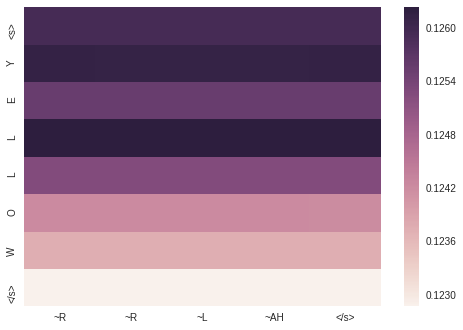

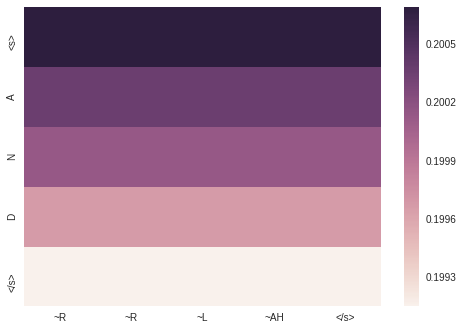

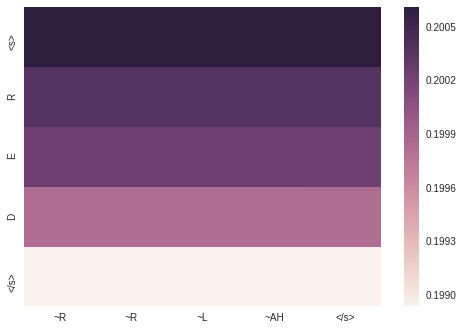

= R R L AH   R R L AH   R R L AH  
> red


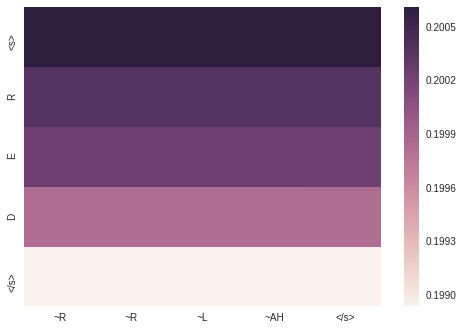

= R R L AH  
> yellow


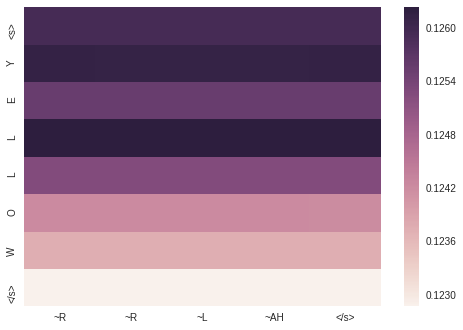

= R R L AH  
> purple


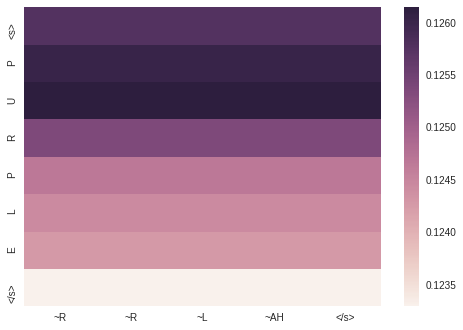

= R R L AH  
> westminster


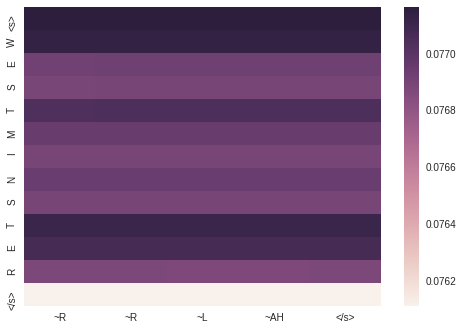

= R R L AH  
> college


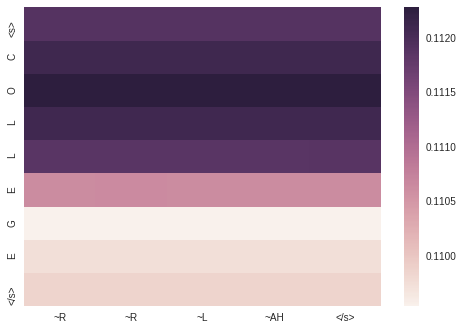

= R R L AH  
> quit


In [0]:
interactive_session(model, vocab, i2w, show_attention=True)